<a href="https://colab.research.google.com/github/AnIsAsPe/Prediccion-produccion-electricidad/blob/main/notebooks/Predicci%C3%B3n_producci%C3%B3n_electricidad_Feb22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [10]:
#import math

import numpy as np
import pandas as pd

import itertools

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt


# Funciones

In [11]:
def p_value_adfuller(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Se rechaza la hipótesis nula, los datos son estacionarios')
        else:
            print('No se rechaza la hipóteis nula, los datos no son estacionarios')


# Lectura de datos

In [12]:
file = 'https://raw.githubusercontent.com/AnIsAsPe/Prediccion-produccion-electricidad/main/Datos/IPG2211A2N_Feb%2022.csv'
datos = pd.read_csv(file, index_col = [0], parse_dates=['DATE'])
datos = datos.loc['1990-01-01':]
datos.columns = ['Producción']  # NAICS 2211

datos

,Producción
DATE,
1990-01-01,83.2897
1990-02-01,76.1676
1990-03-01,72.2190
1990-04-01,66.3566
1990-05-01,64.9348
...,...
2021-10-01,90.6041
2021-11-01,97.5215
2021-12-01,108.1131


In [13]:
# revisamos si las fechas están ordenads
datos.index.is_monotonic

True

In [16]:
datos.index

DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01',
               '1990-05-01', '1990-06-01', '1990-07-01', '1990-08-01',
               '1990-09-01', '1990-10-01',
               ...
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01'],
              dtype='datetime64[ns]', name='DATE', length=386, freq=None)

In [20]:
# para algunas funciones de ST es importante indicar la frecuencia de nuestros datos
datos.index.freq = datos.index.inferred_freq
datos.index

DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01',
               '1990-05-01', '1990-06-01', '1990-07-01', '1990-08-01',
               '1990-09-01', '1990-10-01',
               ...
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01'],
              dtype='datetime64[ns]', name='DATE', length=386, freq='MS')

Para más información de las frecuencias en pandas consultar el apartado DateOffset objects en [este enlace](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

# Exploración y Visualización de la Serie Temporal

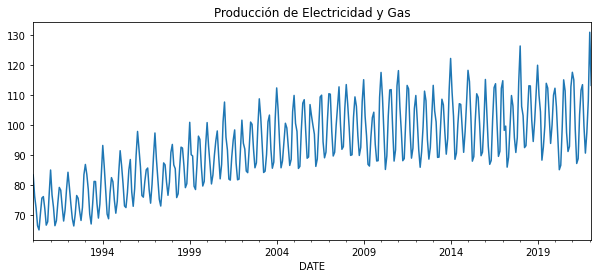

In [21]:
datos['Producción'].plot(figsize=(10,4), title='Producción de Electricidad y Gas')
plt.show()

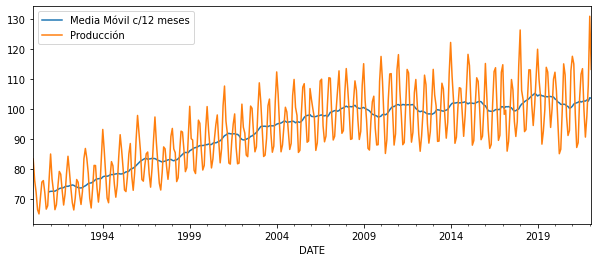

In [22]:
datos['Producción'].rolling(12).mean().plot(figsize=(10,4),label='Media Móvil c/12 meses')
datos['Producción'].plot()
plt.legend()
plt.show()

La funcion seasonal_decompose() de statsmodels, descompone la serie en tres partes: tendencia, estacionalidad y residuos.

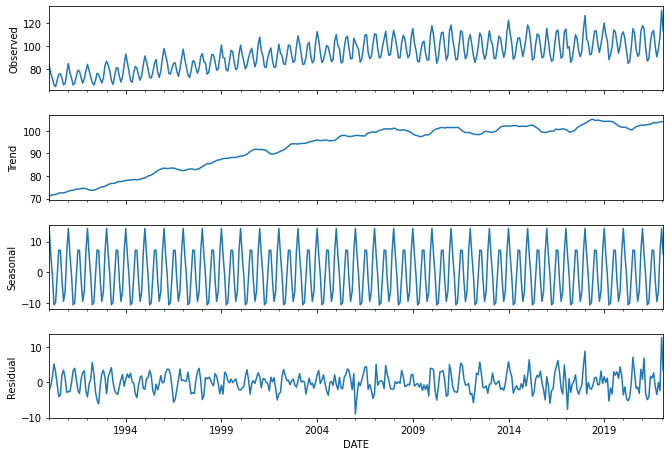

In [23]:
decomp = seasonal_decompose(datos['Producción']
                            , freq=12, extrapolate_trend='freq'
                            )
fig =decomp.plot()
fig.set_size_inches(10,7)

# Convertir los datos a Estacionarios

Realizamos el **test Dickey-Fuller** en la cual, **la hipótesis nula es que los datos no son estacionarios** (*si p es muy pequeña, rechazaremos la hipotesis nula*)
La hipotesis alternativa es que son estacionarios

In [24]:
pValue = adfuller(datos['Producción'])[1]
pValue

0.2555691067075384

In [25]:
p_value_adfuller(datos['Producción'])

P-value:  0.2555691067075384
No se rechaza la hipóteis nula, los datos no son estacionarios


In [26]:
datos['Producción']

DATE
1990-01-01     83.2897
1990-02-01     76.1676
1990-03-01     72.2190
1990-04-01     66.3566
1990-05-01     64.9348
                ...   
2021-10-01     90.6041
2021-11-01     97.5215
2021-12-01    108.1131
2022-01-01    130.9957
2022-02-01    113.2367
Freq: MS, Name: Producción, Length: 386, dtype: float64

In [27]:
 datos['Producción'].shift(1)

DATE
1990-01-01         NaN
1990-02-01     83.2897
1990-03-01     76.1676
1990-04-01     72.2190
1990-05-01     66.3566
                ...   
2021-10-01     99.7176
2021-11-01     90.6041
2021-12-01     97.5215
2022-01-01    108.1131
2022-02-01    130.9957
Freq: MS, Name: Producción, Length: 386, dtype: float64

In [30]:
datos['Producción'].diff()

DATE
1990-01-01        NaN
1990-02-01    -7.1221
1990-03-01    -3.9486
1990-04-01    -5.8624
1990-05-01    -1.4218
               ...   
2021-10-01    -9.1135
2021-11-01     6.9174
2021-12-01    10.5916
2022-01-01    22.8826
2022-02-01   -17.7590
Freq: MS, Name: Producción, Length: 386, dtype: float64

In [31]:
datos['Producción'] - datos['Producción'].shift(1) 

DATE
1990-01-01        NaN
1990-02-01    -7.1221
1990-03-01    -3.9486
1990-04-01    -5.8624
1990-05-01    -1.4218
               ...   
2021-10-01    -9.1135
2021-11-01     6.9174
2021-12-01    10.5916
2022-01-01    22.8826
2022-02-01   -17.7590
Freq: MS, Name: Producción, Length: 386, dtype: float64

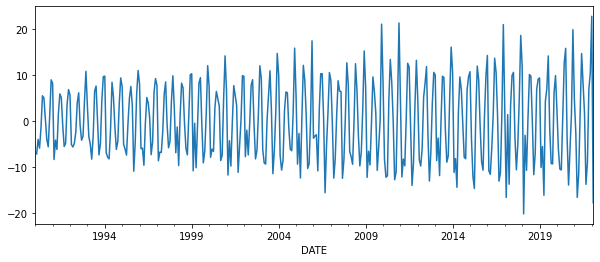

In [33]:
datos['1a diff']= datos['Producción'] - datos['Producción'].shift(1)  
datos['1a diff'].plot(figsize=(10,4))

In [35]:
p_value_adfuller(datos['1a diff'].dropna())

P-value:  9.026604210846001e-10
Se rechaza la hipótesis nula, los datos son estacionarios


# Visualización de la ACF y PACF

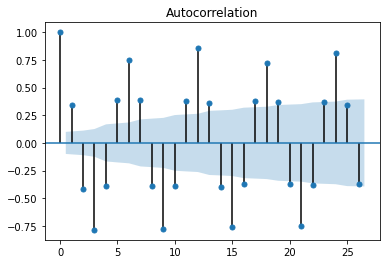

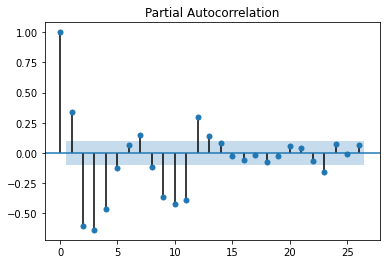

In [36]:
plot_acf(datos['1a diff'].dropna())
plot_pacf(datos['1a diff'].dropna())
plt.show()

# Construcción del modelo SARIMA



In [37]:
train = datos.loc[:'2021-02-01','Producción']
test = datos.loc['2021-02-01':,'Producción']

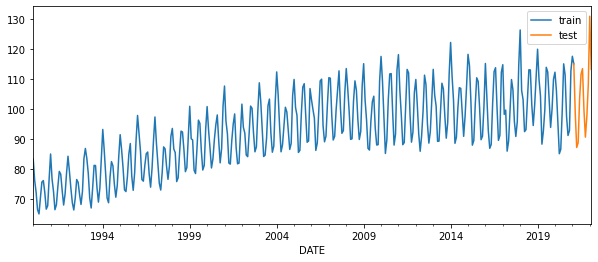

In [38]:
train.plot(label = 'train', figsize =(10,4))
test.plot(label = 'test', figsize =(10,4))
plt.legend()
plt.show()

In [42]:
p =  q = range(0, 2)
p

range(0, 2)

In [44]:
p =  q = range(0, 3)
pdq = list(itertools.product(p, [1], q))
pdq

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [56]:
p = d =  q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 0, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 2, 0, 12),
 (2, 2, 1, 12),
 (2, 2, 2, 12)]

In [57]:
aic_modelos = {}
for parametros in pdq:
  for parametros_s in seasonal_pdq:
      modelo = SARIMAX(datos.loc[:'2021-02-01','Producción'],
                       order = parametros,
                       seasonal_order = parametros_s,
                       enforce_stationarity = False,
                       enforce_invertibility = False)
      results = modelo.fit(method_kwargs={"warn_convergence": False})
      aic_modelos[parametros, parametros_s] = results.aic
      print('ARIMA{} x {} - AIC:{}'.format(parametros, parametros_s, results.aic))  

ARIMA(0, 1, 0) x (0, 0, 0, 12) - AIC:2628.502709893748
ARIMA(0, 1, 0) x (0, 0, 1, 12) - AIC:2286.0055170767682
ARIMA(0, 1, 0) x (0, 0, 2, 12) - AIC:2102.920926464207
ARIMA(0, 1, 0) x (0, 1, 0, 12) - AIC:1933.953876054802
ARIMA(0, 1, 0) x (0, 1, 1, 12) - AIC:1751.9879802136034
ARIMA(0, 1, 0) x (0, 1, 2, 12) - AIC:1695.3930312870175
ARIMA(0, 1, 0) x (0, 2, 0, 12) - AIC:2213.697191570723
ARIMA(0, 1, 0) x (0, 2, 1, 12) - AIC:1856.2498343200664
ARIMA(0, 1, 0) x (0, 2, 2, 12) - AIC:1681.4028727221817
ARIMA(0, 1, 0) x (1, 0, 0, 12) - AIC:1929.7886601067917
ARIMA(0, 1, 0) x (1, 0, 1, 12) - AIC:1796.0457257692224
ARIMA(0, 1, 0) x (1, 0, 2, 12) - AIC:1735.8464546094883
ARIMA(0, 1, 0) x (1, 1, 0, 12) - AIC:1840.493532691623
ARIMA(0, 1, 0) x (1, 1, 1, 12) - AIC:1756.348007195169
ARIMA(0, 1, 0) x (1, 1, 2, 12) - AIC:1694.756887843645
ARIMA(0, 1, 0) x (1, 2, 0, 12) - AIC:2025.3514073154472
ARIMA(0, 1, 0) x (1, 2, 1, 12) - AIC:1824.4604388935622
ARIMA(0, 1, 0) x (1, 2, 2, 12) - AIC:1694.8655235305755

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2) x (2, 0, 2, 12) - AIC:1667.3750727797676
ARIMA(0, 1, 2) x (2, 1, 0, 12) - AIC:1673.9271969097463
ARIMA(0, 1, 2) x (2, 1, 1, 12) - AIC:1627.876030558239
ARIMA(0, 1, 2) x (2, 1, 2, 12) - AIC:1615.1429128891268
ARIMA(0, 1, 2) x (2, 2, 0, 12) - AIC:1824.5821513965232
ARIMA(0, 1, 2) x (2, 2, 1, 12) - AIC:1665.9826462305946
ARIMA(0, 1, 2) x (2, 2, 2, 12) - AIC:1615.7913357483494
ARIMA(1, 1, 0) x (0, 0, 0, 12) - AIC:2580.207807701268
ARIMA(1, 1, 0) x (0, 0, 1, 12) - AIC:2269.466907815485
ARIMA(1, 1, 0) x (0, 0, 2, 12) - AIC:2101.5247708520783
ARIMA(1, 1, 0) x (0, 1, 0, 12) - AIC:1914.3499123806882
ARIMA(1, 1, 0) x (0, 1, 1, 12) - AIC:1733.3169760300607
ARIMA(1, 1, 0) x (0, 1, 2, 12) - AIC:1678.3042157362843
ARIMA(1, 1, 0) x (0, 2, 0, 12) - AIC:2194.888832655966
ARIMA(1, 1, 0) x (0, 2, 1, 12) - AIC:1837.4190915146976
ARIMA(1, 1, 0) x (0, 2, 2, 12) - AIC:1657.8271971962263
ARIMA(1, 1, 0) x (1, 0, 0, 12) - AIC:1909.5838508480003
ARIMA(1, 1, 0) x (1, 0, 1, 12) - AIC:1772.6127062995

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2) x (2, 2, 2, 12) - AIC:1608.6137048378466
ARIMA(2, 1, 0) x (0, 0, 0, 12) - AIC:2387.5849086666212
ARIMA(2, 1, 0) x (0, 0, 1, 12) - AIC:2181.1672823128342
ARIMA(2, 1, 0) x (0, 0, 2, 12) - AIC:2048.043576494709
ARIMA(2, 1, 0) x (0, 1, 0, 12) - AIC:1881.378345264618
ARIMA(2, 1, 0) x (0, 1, 1, 12) - AIC:1716.9608264466528
ARIMA(2, 1, 0) x (0, 1, 2, 12) - AIC:1660.0875478107105
ARIMA(2, 1, 0) x (0, 2, 0, 12) - AIC:2152.0911250589047
ARIMA(2, 1, 0) x (0, 2, 1, 12) - AIC:1809.571454016203
ARIMA(2, 1, 0) x (0, 2, 2, 12) - AIC:1643.4087160824527
ARIMA(2, 1, 0) x (1, 0, 0, 12) - AIC:1877.7409687844922
ARIMA(2, 1, 0) x (1, 0, 1, 12) - AIC:1753.7634262043266
ARIMA(2, 1, 0) x (1, 0, 2, 12) - AIC:1698.8095388169036
ARIMA(2, 1, 0) x (1, 1, 0, 12) - AIC:1789.9719764292984
ARIMA(2, 1, 0) x (1, 1, 1, 12) - AIC:1716.0258175001281
ARIMA(2, 1, 0) x (1, 1, 2, 12) - AIC:1660.2756006001068
ARIMA(2, 1, 0) x (1, 2, 0, 12) - AIC:1969.8463262493674
ARIMA(2, 1, 0) x (1, 2, 1, 12) - AIC:1779.106950831

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0) x (2, 0, 2, 12) - AIC:1693.938946631518
ARIMA(2, 1, 0) x (2, 1, 0, 12) - AIC:1695.0886377114498
ARIMA(2, 1, 0) x (2, 1, 1, 12) - AIC:1649.508435366682
ARIMA(2, 1, 0) x (2, 1, 2, 12) - AIC:1649.507268377347
ARIMA(2, 1, 0) x (2, 2, 0, 12) - AIC:1839.7765515126432
ARIMA(2, 1, 0) x (2, 2, 1, 12) - AIC:1681.4535438804878
ARIMA(2, 1, 0) x (2, 2, 2, 12) - AIC:1646.8038718854034
ARIMA(2, 1, 1) x (0, 0, 0, 12) - AIC:2168.0390723540886
ARIMA(2, 1, 1) x (0, 0, 1, 12) - AIC:2000.3301593402477
ARIMA(2, 1, 1) x (0, 0, 2, 12) - AIC:1919.5776471847898
ARIMA(2, 1, 1) x (0, 1, 0, 12) - AIC:1848.801840739678
ARIMA(2, 1, 1) x (0, 1, 1, 12) - AIC:1673.6594721277313
ARIMA(2, 1, 1) x (0, 1, 2, 12) - AIC:1620.1685876919723
ARIMA(2, 1, 1) x (0, 2, 0, 12) - AIC:2125.7486771728436
ARIMA(2, 1, 1) x (0, 2, 1, 12) - AIC:1776.1737237939305
ARIMA(2, 1, 1) x (0, 2, 2, 12) - AIC:1606.020576535932
ARIMA(2, 1, 1) x (1, 0, 0, 12) - AIC:1839.7025154128473
ARIMA(2, 1, 1) x (1, 0, 1, 12) - AIC:1720.54556043943

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1) x (1, 2, 2, 12) - AIC:1608.9518967584115
ARIMA(2, 1, 1) x (2, 0, 0, 12) - AIC:1754.1970700801126
ARIMA(2, 1, 1) x (2, 0, 1, 12) - AIC:1672.539266269728


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1) x (2, 0, 2, 12) - AIC:1663.8205975228775
ARIMA(2, 1, 1) x (2, 1, 0, 12) - AIC:1654.8976143890254
ARIMA(2, 1, 1) x (2, 1, 1, 12) - AIC:1612.1419092670137
ARIMA(2, 1, 1) x (2, 1, 2, 12) - AIC:1613.7408751371368
ARIMA(2, 1, 1) x (2, 2, 0, 12) - AIC:1799.3837750963373
ARIMA(2, 1, 1) x (2, 2, 1, 12) - AIC:1644.249247719326
ARIMA(2, 1, 1) x (2, 2, 2, 12) - AIC:1614.160856583851
ARIMA(2, 1, 2) x (0, 0, 0, 12) - AIC:2015.012569465404
ARIMA(2, 1, 2) x (0, 0, 1, 12) - AIC:1874.7307763728338


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2) x (0, 0, 2, 12) - AIC:1808.6327173485965
ARIMA(2, 1, 2) x (0, 1, 0, 12) - AIC:1841.066983050081
ARIMA(2, 1, 2) x (0, 1, 1, 12) - AIC:1671.4417187792724
ARIMA(2, 1, 2) x (0, 1, 2, 12) - AIC:1618.2083441321997
ARIMA(2, 1, 2) x (0, 2, 0, 12) - AIC:2105.450517305822
ARIMA(2, 1, 2) x (0, 2, 1, 12) - AIC:1771.4990797401895


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2) x (0, 2, 2, 12) - AIC:1602.3222112303342
ARIMA(2, 1, 2) x (1, 0, 0, 12) - AIC:1838.630825498185


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2) x (1, 0, 1, 12) - AIC:1718.5570861630931


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2) x (1, 0, 2, 12) - AIC:1665.5680279828925
ARIMA(2, 1, 2) x (1, 1, 0, 12) - AIC:1756.3095697560534
ARIMA(2, 1, 2) x (1, 1, 1, 12) - AIC:1673.4411964769208
ARIMA(2, 1, 2) x (1, 1, 2, 12) - AIC:1615.928686387703
ARIMA(2, 1, 2) x (1, 2, 0, 12) - AIC:1933.8434284446178
ARIMA(2, 1, 2) x (1, 2, 1, 12) - AIC:1743.3560997087807
ARIMA(2, 1, 2) x (1, 2, 2, 12) - AIC:1615.0265482905331
ARIMA(2, 1, 2) x (2, 0, 0, 12) - AIC:1756.1297236394942


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2) x (2, 0, 1, 12) - AIC:1674.589815681365


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2) x (2, 0, 2, 12) - AIC:1661.8011507576011
ARIMA(2, 1, 2) x (2, 1, 0, 12) - AIC:1656.3957646542951
ARIMA(2, 1, 2) x (2, 1, 1, 12) - AIC:1614.0771984855196
ARIMA(2, 1, 2) x (2, 1, 2, 12) - AIC:1610.5008754406063
ARIMA(2, 1, 2) x (2, 2, 0, 12) - AIC:1800.2574443620206
ARIMA(2, 1, 2) x (2, 2, 1, 12) - AIC:1645.955684611256
ARIMA(2, 1, 2) x (2, 2, 2, 12) - AIC:1610.668235537456


In [58]:
print('Modelo: ', min(aic_modelos, key = aic_modelos.get))
print('AIC: ',min(aic_modelos.values()))


Modelo:  ((1, 1, 2), (0, 2, 2, 12))
AIC:  1601.2855651509656


In [61]:
modelo = SARIMAX(datos['Producción'],
                       order = (1,1,2),
                       seasonal_order = (0,2,2,12),
                       enforce_stationarity = False,
                       enforce_invertibility = False)
resultados = modelo.fit()
print(resultados.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6007      0.126      4.763      0.000       0.353       0.848
ma.L1         -1.1501      0.148     -7.789      0.000      -1.439      -0.861
ma.L2          0.1836      0.130      1.411      0.158      -0.071       0.439
ma.S.L12      -2.1320      0.060    -35.318      0.000      -2.250      -2.014
ma.S.L24       1.1552      0.057     20.122      0.000       1.043       1.268
sigma2         5.6204      0.555     10.129      0.000       4.533       6.708


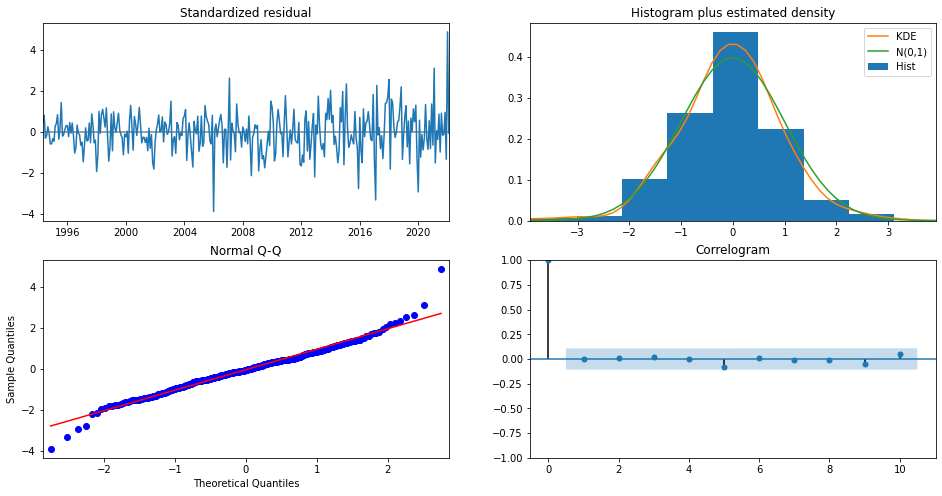

In [62]:
resultados.plot_diagnostics(figsize = (16,8))
plt.show()

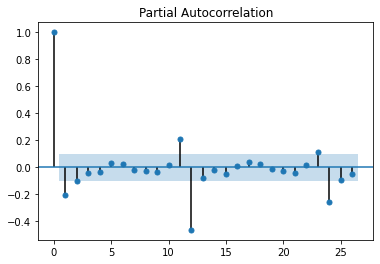

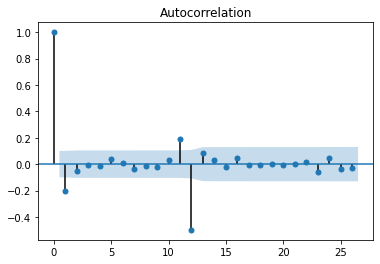

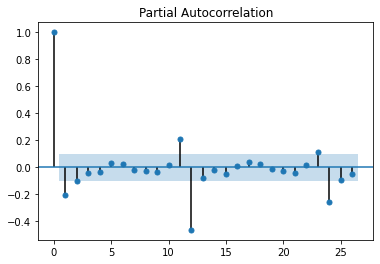

In [69]:
resultados.resid
plot_acf(resultados.resid)
plot_pacf(resultados.resid)

# Validación

In [70]:
pred = resultados.get_prediction(start=pd.to_datetime('2021-02-01'),
                                 end=pd.to_datetime('2022-06-01'))
pred.predicted_mean

2021-02-01    106.560527
2021-03-01    102.659134
2021-04-01     87.002510
2021-05-01     89.764971
2021-06-01    101.121946
2021-07-01    114.365611
2021-08-01    111.010651
2021-09-01    100.178761
2021-10-01     90.961894
2021-11-01     94.918910
2021-12-01    111.804712
2022-01-01    117.626283
2022-02-01    113.414708
2022-03-01    102.392094
2022-04-01     88.786542
2022-05-01     90.880616
2022-06-01    102.974665
Freq: MS, dtype: float64

In [71]:
#intervalo de confianza
pred_IC = pred.conf_int()
pred_IC

,lower Producción,upper Producción
2021-02-01,101.185251,111.935803
2021-03-01,97.283912,108.034355
2021-04-01,81.627299,92.377721
2021-05-01,84.389785,95.140156
2021-06-01,95.746788,106.497104
2021-07-01,108.990479,119.740743
2021-08-01,105.635543,116.385759
2021-09-01,94.803675,105.553847
2021-10-01,85.586828,96.336960
2021-11-01,89.543863,100.293957


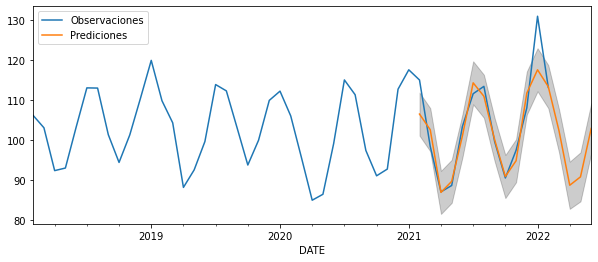

In [72]:
fig = datos.loc['2018-02-01':,'Producción'].plot(label = 'Observaciones', 
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index, 
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1], 
                 color='k', alpha=.2)
plt.legend()
plt.show()

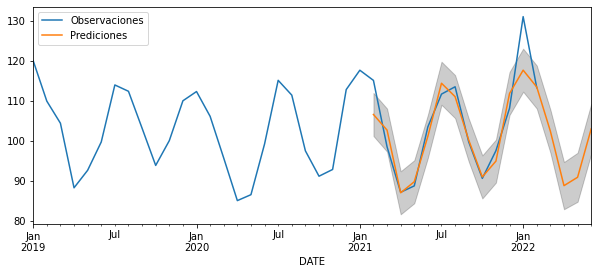

In [73]:
fig = datos.loc['2019-01-01':,'Producción'].plot(label = 'Observaciones', 
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index, 
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1], 
                 color='k', alpha=.2)
plt.legend()
plt.show()

In [74]:
y_pred  = pred.predicted_mean
y_real = datos.loc['2021-02-01':'2022-02-01','Producción']
mse = ((y_pred - y_real) ** 2).mean()
print('El error cuadrático medio es {}'.format(round(mse, 2)))
print('La raiz del error cuadrático medio es {}'.format(round(np.sqrt(mse), 2)))

El error cuadrático medio es 23.81
La raiz del error cuadrático medio es 4.88
